#Task 1 : Hierarchical clustering in non-Euclidean spaces

In [ ]:
# Cell 1: Imports and Setup
from random import choice, randint
from string import ascii_letters
from collections import deque
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import csv
from tqdm import tqdm

In [ ]:
# Cell 2: Limited Vocabulary Dataset Generation
words = ["".join(choice(ascii_letters) for _ in range(4)) for _ in range(10)]
dataset = []

for i in range(10000):
    r = [i]
    s = ""
    length = randint(32, 64)

    while len(s) < length:
        s += choice(words)

    r.append(s)
    r.append([s[j : j + 4] for j in range(len(s) - 3)])
    dataset.append(r)

In [ ]:
# Cell 3: Save to CSV
with open("dataset.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(["index", "string", "shingles"])
    w.writerows(dataset)

In [ ]:
# Cell 4: Load Dataset
df = pd.read_csv("dataset.csv", index_col="index")
df["shingles"] = df["shingles"].apply(literal_eval)

In [ ]:
# Cell 5: Binarize with MultiLabelBinarizer
features = MultiLabelBinarizer().fit_transform(df["shingles"].apply(lambda x: map(str.casefold, x)))

In [ ]:
# Cell 6: Agglomerative Clustering with NN-Chain and Progress
class AgglomerativeClustering:
    def __init__(self, n_clusters=3, jump_threshold=None, seed=42):
        self.n_clusters = n_clusters
        self.jump_threshold = jump_threshold
        self.seed = seed

    def fit(self, X):
        clusters = pd.DataFrame(
            [(i, [i]) for i in range(len(X))],
            columns=["clustroid", "points"],
        )

        stack = deque([])
        rng = np.random.default_rng(self.seed)
        last_diameter = 0

        pbar = tqdm(total=len(clusters) - self.n_clusters - 1, desc="Clustering")

        while len(clusters) > self.n_clusters + 1:
            if len(stack) == 0:
                stack.appendleft(
                    clusters["clustroid"].sample(1, random_state=rng).item()
                )

            cid = stack[0]
            clustroids = clusters.loc[
                clusters["clustroid"] != cid, "clustroid"
            ].values

            dist = X[clustroids, :]
            s = dist.dot(X[cid])
            u = X.shape[1] - (1 - dist).dot(1 - X[cid])
            jd = 1 - s / u
            d = clustroids[jd.argmin()]

            if d in stack:
                stack.popleft()
                stack.remove(d)

                points = np.array(
                    clusters.loc[clusters["clustroid"] == d, "points"].item()
                    + clusters.loc[clusters["clustroid"] == cid, "points"].item()
                )

                dist = X[points, :]
                odist = dist.T

                s = dist.dot(odist)
                u = X.shape[1] - (1 - dist).dot(1 - odist)
                jd = 1 - s / u

                if self.jump_threshold is not None:
                    diameter = jd.max()

                    if np.abs(last_diameter - diameter) > self.jump_threshold:
                        print(
                            f"Merging clusters with clustroid {cid} and {d} yielded a bad cluster with a jump of {np.abs(last_diameter - diameter)}."
                        )
                        break

                    last_diameter = diameter

                clustroid = points[np.square(jd).sum(axis=1).argmin()]

                clusters.loc[clusters["clustroid"] == cid, "clustroid"] = clustroid
                clusters.loc[clusters["clustroid"] == d, "clustroid"] = clustroid
                clusters = clusters.groupby(["clustroid"], as_index=False).agg(
                    {"points": "sum"}
                )

                pbar.update(1)
            else:
                stack.appendleft(d)

        pbar.close()

        self.labels = (
            clusters.explode("points").sort_values("points")["clustroid"].values
        )

        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

In [ ]:
# Cell 7: Run Clustering
ac = AgglomerativeClustering(n_clusters=10, jump_threshold=0.8, seed=42)
labels = ac.fit_predict(features)

Clustering: 100%|██████████| 9989/9989 [07:17<00:00, 22.83it/s]


In [ ]:
# Cell 8: View Clustroids and Sample Strings
clustroids = np.sort(np.unique(labels))
strings = df.iloc[clustroids]["string"]
strings

,string
index,
585,npnkGjqlGjqlvWqxGjqliziTplznplznvWqxGjql
1790,plznaUabnpnkFnnOGGNFaUabGGNFHCUKaUabGjqlFnnOHC...
2602,iziTnpnkGjqlvWqxnpnkGGNFHCUKnpnkaUabnDKJFnnOnp...
3415,vWqxvWqxnpnknpnkGGNFGGNFiziTHCUKvWqx
3496,HCUKvWqxFnnOaUabiziTvWqxaUabnDKJvWqxFnnOnpnkvW...
4586,vWqxnDKJnDKJHCUKaUabiziTnDKJHCUK
4967,GGNFvWqxFnnOiziTGjqlnpnkFnnOiziTFnnO
6783,iziTHCUKnDKJHCUKHCUKiziTiziTiziTnpnkFnnOnDKJHCUK
7036,HCUKiziTHCUKiziTplznaUabHCUKGGNFnpnkiziTFnnO


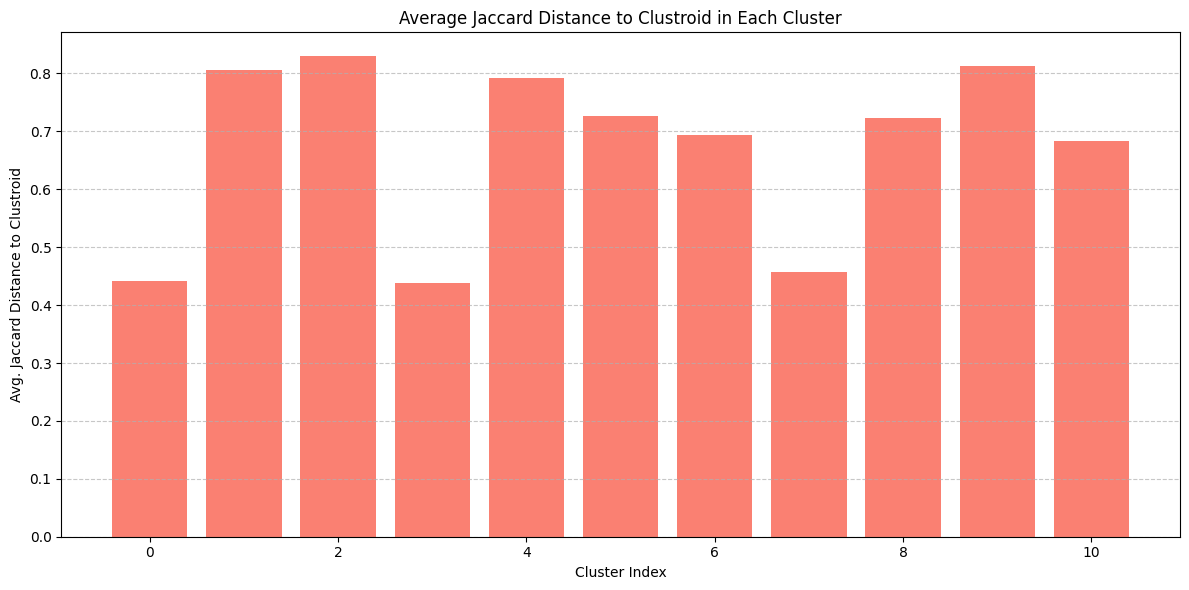

In [ ]:
# Cell 9: Average Intra-cluster Jaccard Distance
import matplotlib.pyplot as plt

ajd = []

for c in clustroids:
    ft = features[np.argwhere(labels == c).flatten()]
    cf = features[c]
    s = ft.dot(cf)
    u = features.shape[1] - (1 - ft).dot(1 - cf)
    jds = 1 - s / u
    ajd.append(jds.mean())

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(ajd)), ajd, color='salmon')
plt.xlabel("Cluster Index")
plt.ylabel("Avg. Jaccard Distance to Clustroid")
plt.title("Average Jaccard Distance to Clustroid in Each Cluster")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()